# Downloading CSDA data

[NASA's](https://www.nasa.gov/) [Commercial Satellite Data Acquisition (CSDA)](https://www.earthdata.nasa.gov/about/csda) program acquires, catalogs, and provides commercial satellite data for the scientific community.
The program's services include a [SpatioTemporal Asset Catalog](https://stacspec.org/) API server for searching and discovering CSDA assets.
We'll use [pystac-client](https://github.com/stac-utils/pystac-client) to search the CSDA STAC API for items that we can use.
The CSDA STAC API is public and open, meaning that we don't need any authorization or authentication to use it.

Before getting started, we import all the Python packages, classes, and functions that we need, and define a few helpful constants.

In [20]:
import getpass
import json
from pathlib import Path
from tempfile import TemporaryDirectory

import contextily
import cql2
import humanize
import rasterio
import rasterio.plot
import tabulate
import tqdm
from geopandas import GeoDataFrame
from pystac_client import Client

from csda_client import CsdaClient

LONGMONT_CO_USA = {"type": "Point", "coordinates": [-105.1019, 40.1672]}

## Collection search

CSDA includes data from several [vendors](https://www.earthdata.nasa.gov/about/csda#toc-vendors).
Each vendor maps onto a single [STAC Collection](https://github.com/radiantearth/stac-spec/blob/master/collection-spec/collection-spec.md), and we can use our STAC API to discover which vendors are available.

### Why are there warnings?

The CSDA STAC catalog currently contains some invalid STAC Collections.
We're working on updating those, and when we do, the warnings will go away.

In [21]:
stac_client = Client.open("https://csdap.earthdata.nasa.gov/stac/")
rows = []
for collection in stac_client.collection_search().collections_as_dicts():
    rows.append([collection["id"], collection.get("title")])

tabulate.tabulate(rows, headers=["collection", "title"], tablefmt="html")

/Users/gadomski/Code/nasa-impact/csda-client/.venv/lib/python3.10/site-packages/pystac_client/collection_search.py:121: PystacClientWarning: Unable to parse extent from collection=ghgsat
  warnings.warn(
/Users/gadomski/Code/nasa-impact/csda-client/.venv/lib/python3.10/site-packages/pystac_client/collection_search.py:121: PystacClientWarning: Unable to parse extent from collection=geooptics
  warnings.warn(
/Users/gadomski/Code/nasa-impact/csda-client/.venv/lib/python3.10/site-packages/pystac_client/collection_search.py:121: PystacClientWarning: Unable to parse extent from collection=capellaspace
  warnings.warn(
/Users/gadomski/Code/nasa-impact/csda-client/.venv/lib/python3.10/site-packages/pystac_client/collection_search.py:121: PystacClientWarning: Unable to parse extent from collection=planet
  warnings.warn(
/Users/gadomski/Code/nasa-impact/csda-client/.venv/lib/python3.10/site-packages/pystac_client/collection_search.py:121: PystacClientWarning: Unable to parse extent from collec

collection,title
ghgsat,
geooptics,GeoOptics
capellaspace,CapellaSpace
desis,DESIS
planet,Planet
spire,Spire
iceye,Iceye
airbus,Airbus
earthdem,EarthDEM
blacksky,Blacksky


## Finding Planet data

One of the CSDA vendors, [Planet](https://www.planet.com/), collects imagery that is easy to visualize and interpret, so let's use their data for this notebook.
We can use a [STAC API search query](https://github.com/radiantearth/stac-api-spec/tree/release/v1.0.0/item-search#query-parameter-table) to narrow our request.
In this example, we'll find [STAC items](https://github.com/radiantearth/stac-spec/blob/master/item-spec/item-spec.md) that:

- are in the `planet` collection
- Have a cloud cover of less than or equal to 25%
- Were collected in 2021
- Intersect [Longmont, CO, USA](https://en.wikipedia.org/wiki/Longmont,_Colorado)

### What's the deal with the `cql2` stuff?

[cql2](https://www.ogc.org/standards/cql2/) is an [Open Geospatial Consortium](https://www.ogc.org/) standard for querying spatial data.
Our STAC API only understands `cql2-json`, but `cql2-json` can be a little awkward to write.
`cql2-text` is much more intuitive, so we write that and then convert it to `cql2-json` using [this helper package](https://github.com/developmentseed/cql2-rs/).
This should become automatic via **pystac-client** [soon](https://github.com/stac-utils/pystac-client/issues/803).

In [22]:
item_search = stac_client.search(
    collections=["planet"],
    intersects=LONGMONT_CO_USA,
    filter=cql2.parse_text("eo:cloud_cover<25").to_json(),
    datetime="2021",
)
item_collection = item_search.item_collection()
print(len(item_collection))

18


Let's visualize the items, first as a `GeoDataFrame`.

In [23]:
data_frame = GeoDataFrame.from_features(item_collection.to_dict(), crs="EPSG:4326")
data_frame.head(5)

,geometry,eo:gsd,eo:epsg,pl:rows,datetime,eo:bands,eo:azimuth,pl:columns,pl:updated,pl:origin_x,...,pl:anomalous_pixels,pl:pixel_resolution,pl:publishing_stage,pl:quality_category,pl:snow_ice_percent,pl:heavy_haze_percent,pl:light_haze_percent,pl:clear_confidence_percent,pl:visible_confidence_percent,pl:ps4b_geometry
0,"POLYGON ((-105.34272 40.22107, -105.3952 40.03...",4.0,32613.0,9524.0,2021-12-30T16:54:34.641952Z,[],101.0,13191.0,2021-12-31T03:59:48Z,466281.0,...,0,3,finalized,test,0,0,0,97,72,NaN
1,"POLYGON ((-105.46945 40.24533, -105.5246 40.05...",4.0,32613.0,9595.0,2021-12-20T17:00:46.336281Z,[],278.6,13244.0,2021-12-21T04:28:04Z,455256.0,...,0,3,finalized,standard,0,0,0,96,74,NaN
2,"POLYGON ((-105.49219 40.32051, -105.54659 40.1...",4.1,32613.0,9715.0,2021-12-01T17:44:27.408844Z,[],111.8,13382.0,2021-12-02T10:03:46Z,453429.0,...,0,3,finalized,standard,0,0,0,97,59,NaN
3,"POLYGON ((-105.22817 40.32841, -105.28215 40.1...",4.1,NaN,NaN,2021-11-28T16:54:46.363155Z,[],100.9,NaN,2022-10-27T11:45:48Z,NaN,...,0,3,finalized,standard,0,0,0,98,77,"{'type': 'Polygon', 'coordinates': [[[-105.228..."
4,"POLYGON ((-105.18108 40.18135, -105.23515 39.9...",4.0,NaN,NaN,2021-11-25T17:11:14.321045Z,[],276.5,NaN,2022-10-30T06:51:29Z,NaN,...,0,3,finalized,standard,0,0,0,99,99,NaN


Then, on a map (it's pretty noisy).

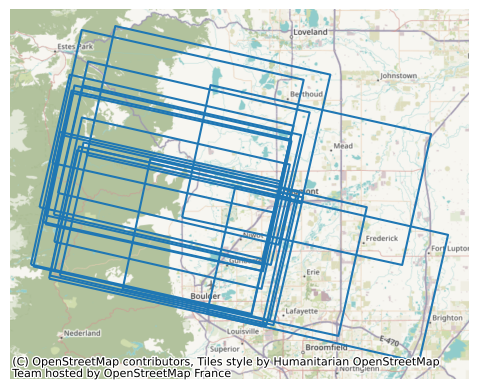

In [24]:
axes = data_frame.to_crs(epsg=3857).boundary.plot()
contextily.add_basemap(axes)
axes.set_axis_off()

If you happen to know your item (granule) id, you can fetch that item directly and see it's assets dictionary.

In [25]:
item = next(
    stac_client.search(
        collections=["planet"], ids=["PSScene-20250706_160525_67_24c6"]
    ).items()
)
item

<Item id=PSScene-20250706_160525_67_24c6>

In [26]:
item.assets

{'thumbnail': <Asset href=https://ss-ingest-dev-thumbnails115905a6-1qhb7abvyj8pc.s3.amazonaws.com/planet/PSScene-20250706_160525_67_24c6/thumb>,
 'basic_udm2': <Asset href=s3://ss-ingest-prod-ingesteddata-uswest2/storage-ss-ingest-prod-ingesteddata-uswest2/planet/PSScene-20250706_160525_67_24c6/assets/basic_udm2/20250706_160525_67_24c6_1A_udm2.tif>,
 'ortho_udm2': <Asset href=s3://ss-ingest-prod-ingesteddata-uswest2/storage-ss-ingest-prod-ingesteddata-uswest2/planet/PSScene-20250706_160525_67_24c6/assets/ortho_udm2/20250706_160525_67_24c6_3B_udm2.tif>,
 'ortho_visual': <Asset href=s3://ss-ingest-prod-ingesteddata-uswest2/storage-ss-ingest-prod-ingesteddata-uswest2/planet/PSScene-20250706_160525_67_24c6/assets/ortho_visual/20250706_160525_67_24c6_3B_Visual.tif>,
 'json_metadata': <Asset href=s3://ss-ingest-prod-ingesteddata-uswest2/storage-ss-ingest-prod-ingesteddata-uswest2/planet/PSScene-20250706_160525_67_24c6/assets/json_metadata/20250706_160525_67_24c6_metadata.json>,
 'basic_analy

## Download assets

While the STAC API is open, the [CSDA Orders API](https://csdap.earthdata.nasa.gov/api) requires authentication.
You'll use your [Earthdata login](https://urs.earthdata.nasa.gov/) username and password to log in.

In [27]:
username = input("Earthdata username: ")
password = getpass.getpass("Earthdata password: ")

Logging into CSDA creates an access token that encodes your download quotas, among other information.

In [28]:
client = CsdaClient.open(username=username, password=password)
response = client.request("/api/v1/auth/verify", method="GET")
response.raise_for_status()
response.json()

'Hello gadomski, you have a valid token!'

First, let's see how much quota you have for the `planet` collection.
The `/signup` endpoint, from our Data Auth API, provides information on how much quota you have been allocated.

In [29]:
response = client.request(f"/signup/api/users/{username}", method="GET")
response.raise_for_status()
planet = next(
    vendor for vendor in response.json()["vendors"] if vendor["slug"] == "planet"
)
print(json.dumps(planet, indent=2))

{
  "vendor": "Planet",
  "slug": "planet",
  "quota": 5000000,
  "quota_unit": "area",
  "approved": true,
  "approved_date": "2024-10-16",
  "expiration_date": "2025-12-31",
  "notes": "",
  "preview_approved": false
}


The `/api/v1/download/summary` endpoint provide information on data you have downloaded in the past.

In [30]:
response = client.request(
    f"/api/v1/download/summary?username={username}&provider=planet", method="GET"
)
response.raise_for_status()
print(json.dumps(response.json(), indent=2))

[
  {
    "username": "gadomski",
    "provider": "planet",
    "updated_at": "2025-03-11T20:24:02.808930Z",
    "area": 10792,
    "filesize": 28913041658
  }
]


As long as the sum of all of your `area` is less than your `quota`, you're good to download data!
To create a new order, let's first identify the item ids that we want to order.
For cost-saving, we regularly move "older" data (data that was provided to the program a long time ago) to "cold" storage, meaning that it can't be quickly downloaded.
For this demonstration, we cheat a bit and use an item that we _know_ isn't in cold storage (for now).

In [31]:
item_search = stac_client.search(
    collections=["planet"],
    ids=["PSScene-20250513_160742_95_253a"],
)
item_collection = item_search.item_collection()
assert len(item_collection) == 1
data_frame = GeoDataFrame.from_features(item_collection.to_dict())
data_frame

,geometry,eo:gsd,datetime,eo:bands,eo:azimuth,pl:updated,pl:provider,pl:strip_id,eo:off_nadir,pl:item_type,...,pl:visible_percent,pl:anomalous_pixels,pl:pixel_resolution,pl:publishing_stage,pl:quality_category,pl:snow_ice_percent,pl:heavy_haze_percent,pl:light_haze_percent,pl:clear_confidence_percent,pl:visible_confidence_percent
0,"POLYGON ((-72.47785 42.70292, -72.5326 42.5210...",3.9,2025-05-13T16:07:42.957137Z,[],270.6,2025-05-14T03:55:05Z,planetscope,8063802,1.2,PSScene,...,94,0,3,finalized,standard,0,0,79,80,71


The item has several assets.

In [32]:
item = item_collection[0]
rows = []
for key, asset in item.assets.items():
    if file_size := asset.ext.file.size:
        humanized_file_size = humanize.naturalsize(file_size)
    else:
        humanized_file_size = None
    if roles := asset.roles:
        humanized_roles = humanize.natural_list(roles)
    else:
        humanized_roles = roles
    rows.append([key, humanized_roles, asset.media_type, humanized_file_size])
tabulate.tabulate(
    rows, headers=["Key", "Roles", "Type", "File size", "Roles"], tablefmt="html"
)

Key,Roles,Type,File size
thumbnail,thumbnail,,
basic_udm2,data,image/tiff,4.6 MB
ortho_udm2,data,image/tiff,8.2 MB
ortho_visual,data,image/tiff,200.3 MB
json_metadata,metadata,application/json,975 Bytes
basic_analytic_4b,data,image/tiff,352.6 MB
basic_analytic_8b,data,image/tiff,714.4 MB
ortho_analytic_4b,data,image/tiff,586.8 MB
ortho_analytic_8b,data,image/tiff,1.2 GB
ortho_analytic_4b_sr,data,image/tiff,494.2 MB


Let's download the ortho visual asset.

 97%|█████████▋| 185M/191M [00:02<00:00, 66.4MB/s] 

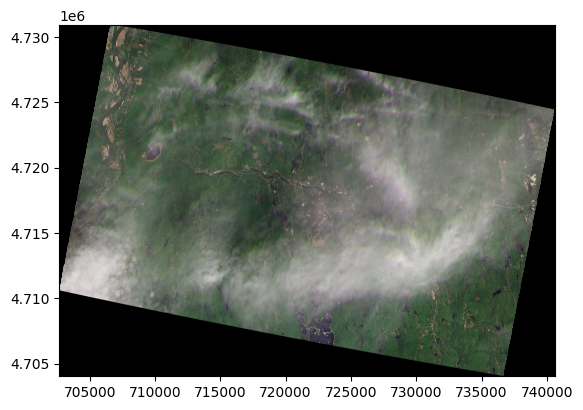

In [33]:
path = f"/api/v2/download/{item.collection_id}/{item.id}/ortho_visual"
response = client.request(path=path, method="GET", allow_redirects=True, stream=True)
response.raise_for_status()
with TemporaryDirectory() as temporary_directory:
    local_path = Path(temporary_directory) / "ortho_visual.tif"
    progress_bar = progress_bar = tqdm.tqdm(
        total=item.assets["ortho_visual"].ext.file.size,
        unit="B",
        unit_divisor=1024,
        miniters=1,
        unit_scale=True,
    )
    with open(local_path, "wb") as f:
        for chunk in response.iter_content(1024 * 8):
            if chunk:
                f.write(chunk)
                progress_bar.update(len(chunk))
            else:
                progress_bar.close()

    with rasterio.open(local_path) as dataset:
        rasterio.plot.show(dataset)